In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter,OrderedDict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix,precision_score,auc,plot_confusion_matrix,plot_roc_curve,accuracy_score,f1_score
import pickle
import tensorflow as tf
import keras 
from keras.models import Model,Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Bidirectional,TextVectorization
from keras.metrics import Precision,Recall,BinaryAccuracy
from wordcloud import WordCloud

In [32]:
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()

In [ ]:
df=pd.DataFrame()
labels={'pos':1,'neg':0}
for i in ('train','test'):
    for j in ('pos','neg'):
        path=os.path.join(i,j)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path,file),'r',encoding='utf-8') as rawData:
                txt=rawData.read()
                df=df.append([[txt,labels[j]]],ignore_index=True)

df.columns=['text','sentiment']
df=df.sample(frac=1).reset_index(drop=True) ## Shuffles the dataframe
df.to_csv('imdb_reviews.csv',index=False,encoding='utf-8') ## Helpsin loading the reviews easily the next time

In [3]:
df=pd.read_csv('imdb_reviews.csv')

In [4]:
def preprocess(text):
    text=re.sub('<[^>]*>','',text) ## Removes HTML Markups
    text=re.sub('\n','',text) ## Removes newline
    text=re.sub(' +',' ',text) ## Removes multiple spaces between words
    return text

df['text']=df['text'].apply(preprocess)

Here we are using stopwords dictionary instead of using stopowrds directly to reduce time complexity. Since counter is a dictionary search time complexity is O(1)

In [20]:
# stopwords_list=stopwords.words('english')
# stopwords_dict=Counter(stopwords_list)
def text_process(text):
    text=''.join([x for x in text if x not in string.punctuation])
    text=[x.lower() for x in text.split()]
    return ' '.join(text)

In [19]:
stopwords_list=stopwords.words('english')
stopwords_dict=Counter(stopwords_list)
def text_process2(text):
    text=''.join([x for x in text if x not in string.punctuation])
    text=[x.lower() for x in text.split() if x not in stopwords_dict]
    return ' '.join(text)

In [6]:
df['text'][0]

"This is a superb TV series, it's sympathetic and for once realistic! portrayal of lesbian women is delicately handled and well done. On top of that the directing is wonderful and the settings sumptuous and rich, a real treat. If you missed the first one I advise you watch next weeks, 9PM, BBC 2"

In [7]:
df['text'][:1].apply(text_process)[0]

'this is a superb tv series its sympathetic and for once realistic portrayal of lesbian women is delicately handled and well done on top of that the directing is wonderful and the settings sumptuous and rich a real treat if you missed the first one i advise you watch next weeks 9pm bbc 2'

In [8]:
df['clean_text']=df['text'].apply(text_process)

In [9]:
df

text  sentiment  \
0      This is a superb TV series, it's sympathetic a...        1.0   
1      I loved this film. A must see for any Rod Stei...        1.0   
2      Thats what this movie really takes. A big piec...        0.0   
3      I generally find Loretta Young hard to take, t...        1.0   
4      I'm glad that I saw this film after Mr.Sandler...        0.0   
...                                                  ...        ...   
49995  As I have matured, my fascination with the Aca...        1.0   
49996  Den Brysomme Mannen is one of the better films...        1.0   
49997  Diane Lane, Mickey Rourke, Rosario Dawson & Th...        0.0   
49998  drab morality tale about a high school kid who...        0.0   
49999  'Una Giornata Particolare' is a movie that has...        1.0   

                                              clean_text  
0      this is a superb tv series its sympathetic and...  
1      i loved this film a must see for any rod steig...  
2      thats what this movie really takes a big piece...  
3      i generally find loretta young hard to take to...  
4      im glad that i saw this film after mrsandler b...  
...                                                  ...  
49995  as i have matured my fascination with the acad...  
49996  den brysomme mannen is one of the better films...  
49997  diane lane mickey rourke rosario dawson thomas...  
49998  drab morality tale about a high school kid who...  
49999  una giornata particolare is a movie that has a...  

[50000 rows x 3 columns]

In [10]:
countDF=df.groupby('sentiment',as_index=False).agg({'text':'count'}).rename(columns={'text':'count'})
fig=px.bar(countDF,color='sentiment')
fig.update_layout(xaxis=dict(tickmode='array',tickvals=[0,1],ticktext=['negative','positive'],title='sentiment'),
                 yaxis=dict(title='count'))
fig.update_coloraxes(showscale=False)

In [11]:
df['clean_text_length']=df['clean_text'].apply(len)
fig=px.histogram(df['clean_text_length'])
fig.update_layout(xaxis=dict(title='No of words'))
fig.show()

Most sentences have a length less than 1000 words only.

The original text process used for classification doesn't remove stopwords. <b>text_process2</b> removes stopwords. This is intended to find out the important words in positive and negative reviews. 

In [45]:
df['clean_text2']=df['text'].apply(text_process2)

negative_reviews=' '.join(df[df['sentiment']==0]['clean_text2'])
positive_reviews=' '.join(df[df['sentiment']==1]['clean_text2'])

# Generate a word cloud - negative sentiment
wordcloud_neg = WordCloud(collocation_threshold = 2,
                      collocations= True,
                      background_color="white",
                      colormap="afmhot").generate(negative_reviews)

# Generate a word cloud - positive sentiment
wordcloud_pos = WordCloud(collocation_threshold = 2,
                          collocations= True,
                          background_color="white",
                          colormap="Set1").generate(positive_reviews)

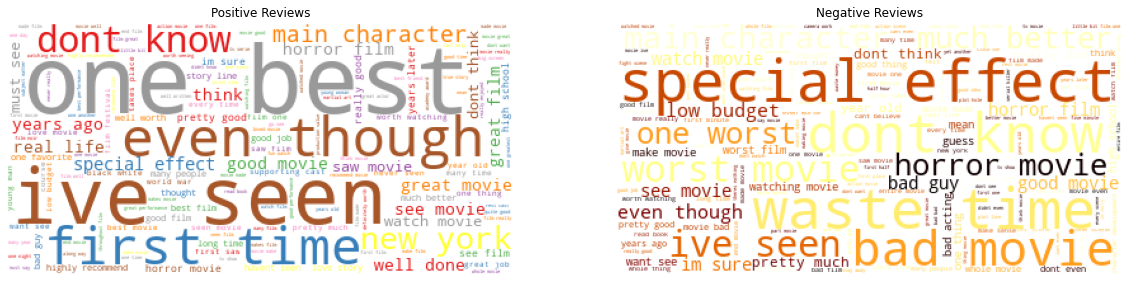

In [61]:
fig=plt.figure(figsize=(20,8))
gs=fig.add_gridspec(1,2)
ax1=fig.add_subplot(gs[0,0])
ax1.imshow(wordcloud_pos)
ax1.axis('off')
ax1.title.set_text('Positive Reviews')
ax2=fig.add_subplot(gs[0,1])
ax2.imshow(wordcloud_neg)
ax2.title.set_text('Negative Reviews')
ax2.axis('off');

In [64]:
# Used to generate bigrams,trigrams and ngrams and calculate frequency distributions of it
# positive_tokens=nltk.word_tokenize(positive_reviews)
# trigrams_positive_tokens=nltk.ngrams(positive_tokens,3)
# trigrams_positive_dict=nltk.FreqDist(trigrams_positive_tokens)
# trigrams_positive_dict

The above word cloud emphasizes the most used words in positive and negative reviews.

In [12]:
x_train=df['clean_text'][:30000].values
x_val=df['clean_text'][30000:40000].values
x_test=df['clean_text'][40000:].values

y_train=df['sentiment'][:30000].values
y_val=df['sentiment'][30000:40000].values
y_test=df['sentiment'][40000:].values

In [50]:
bayes_classifier_pipeline=Pipeline([
    ('bow',CountVectorizer(ngram_range=[1,2])),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [51]:
bayes_classifier_pipeline.fit(x_train,y_train)

Pipeline(steps=[('bow', CountVectorizer(ngram_range=[1, 2])),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

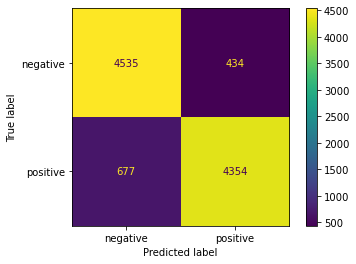

In [18]:
plot_confusion_matrix(bayes_classifier_pipeline,
                      x_val,y_val,
                     display_labels=['negative','positive'])

Text(0.56, 0.2, '0.88')

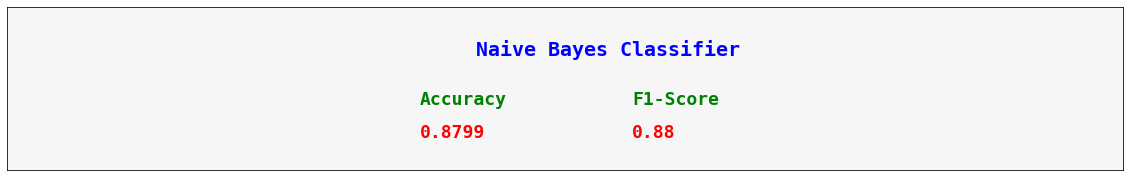

In [19]:
fig=plt.figure(figsize=(20,3))
gs=fig.add_gridspec(1,1)

ax0=fig.add_subplot(gs[0,0])

ax0.set_yticklabels('')
ax0.set_xticklabels('')
ax0.tick_params(axis='both',length=0)
ax0.set_facecolor('#F6F6F6')

ax0.text(0.42,0.7,'Naive Bayes Classifier',fontfamily='monospace',fontweight='bold',fontsize=20,color='blue')

ax0.text(0.37,0.4,'Accuracy',fontfamily='monospace',fontweight='bold',fontsize=18,color='green')
ax0.text(0.37,0.2,str(accuracy_score(y_test,bayes_classifier_pipeline.predict(x_test))),fontfamily='monospace',fontweight='bold',fontsize=18,color='red')

ax0.text(0.56,0.4,'F1-Score',fontfamily='monospace',fontweight='bold',fontsize=18,color='green')
ax0.text(0.56,0.2,str(round(f1_score(y_test,bayes_classifier_pipeline.predict(x_test)),2)),fontfamily='monospace',fontweight='bold',fontsize=18,color='red')

In [13]:
logistic_classifier_pipeline=Pipeline([
    ('bow',CountVectorizer(ngram_range=(1,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',LogisticRegression())
])

In [14]:
logistic_classifier_pipeline.fit(x_train,y_train)

Pipeline(steps=[('bow', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])

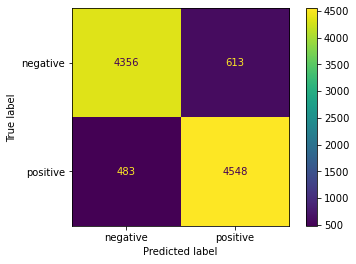

In [15]:
plot_confusion_matrix(logistic_classifier_pipeline,
                      x_val,y_val,
                     display_labels=['negative','positive'])

Text(0.56, 0.2, '0.89')

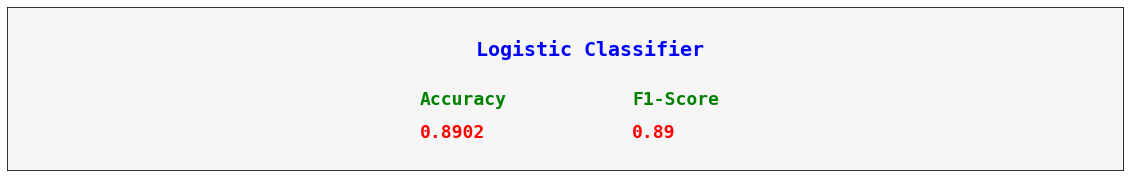

In [16]:
fig=plt.figure(figsize=(20,3))
gs=fig.add_gridspec(1,1)

ax0=fig.add_subplot(gs[0,0])

ax0.set_yticklabels('')
ax0.set_xticklabels('')
ax0.tick_params(axis='both',length=0)
ax0.set_facecolor('#F6F6F6')

ax0.text(0.42,0.7,'Logistic Classifier',fontfamily='monospace',fontweight='bold',fontsize=20,color='blue')

ax0.text(0.37,0.4,'Accuracy',fontfamily='monospace',fontweight='bold',fontsize=18,color='green')
ax0.text(0.37,0.2,str(accuracy_score(y_test,logistic_classifier_pipeline.predict(x_test))),fontfamily='monospace',fontweight='bold',fontsize=18,color='red')

ax0.text(0.56,0.4,'F1-Score',fontfamily='monospace',fontweight='bold',fontsize=18,color='green')
ax0.text(0.56,0.2,str(round(f1_score(y_test,logistic_classifier_pipeline.predict(x_test)),2)),fontfamily='monospace',fontweight='bold',fontsize=18,color='red')

In [25]:
randomForest_classifier_pipeline=Pipeline([
    ('bow',CountVectorizer(ngram_range=[1,2])),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])

In [26]:
randomForest_classifier_pipeline.fit(x_train,y_train)

Pipeline(steps=[('bow', CountVectorizer(ngram_range=[1, 2])),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

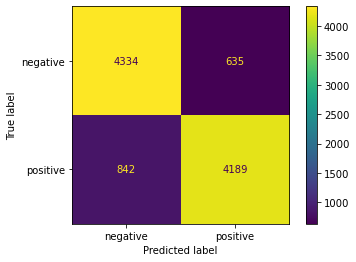

In [28]:
plot_confusion_matrix(randomForest_classifier_pipeline,
                     x_val,y_val,
                     display_labels=['negative','positive'])

Text(0.56, 0.2, '0.85')

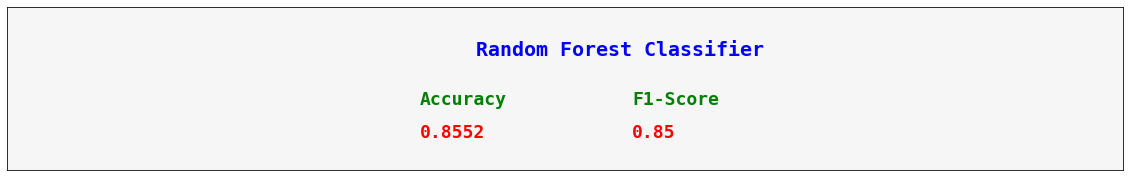

In [29]:
fig=plt.figure(figsize=(20,3))
gs=fig.add_gridspec(1,1)

ax0=fig.add_subplot(gs[0,0])

ax0.set_yticklabels('')
ax0.set_xticklabels('')
ax0.tick_params(axis='both',length=0)
ax0.set_facecolor('#F6F6F6')

ax0.text(0.42,0.7,'Random Forest Classifier',fontfamily='monospace',fontweight='bold',fontsize=20,color='blue')

ax0.text(0.37,0.4,'Accuracy',fontfamily='monospace',fontweight='bold',fontsize=18,color='green')
ax0.text(0.37,0.2,str(accuracy_score(y_test,randomForest_classifier_pipeline.predict(x_test))),fontfamily='monospace',fontweight='bold',fontsize=18,color='red')

ax0.text(0.56,0.4,'F1-Score',fontfamily='monospace',fontweight='bold',fontsize=18,color='green')
ax0.text(0.56,0.2,str(round(f1_score(y_test,randomForest_classifier_pipeline.predict(x_test)),2)),fontfamily='monospace',fontweight='bold',fontsize=18,color='red')

In [31]:
voting_classifier_pipeline=Pipeline([
    ('bow',CountVectorizer(ngram_range=(1,2))),
    ('tfidf',TfidfTransformer()),
    ('voting',VotingClassifier(estimators=[('clf1',MultinomialNB()),('clf2',LogisticRegression()),('clf3',RandomForestClassifier())],
                              voting='hard'))
])

In [35]:
voting_classifier_pipeline.fit(x_train,y_train)

Pipeline(steps=[('bow', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('voting',
                 VotingClassifier(estimators=[('clf1', MultinomialNB()),
                                              ('clf2', LogisticRegression()),
                                              ('clf3',
                                               RandomForestClassifier())]))])

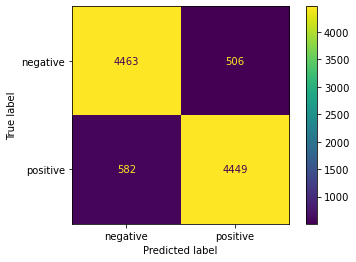

In [36]:
plot_confusion_matrix(voting_classifier_pipeline,
                     x_val,y_val,
                     display_labels=['negative','positive'])

Text(0.56, 0.2, '0.89')

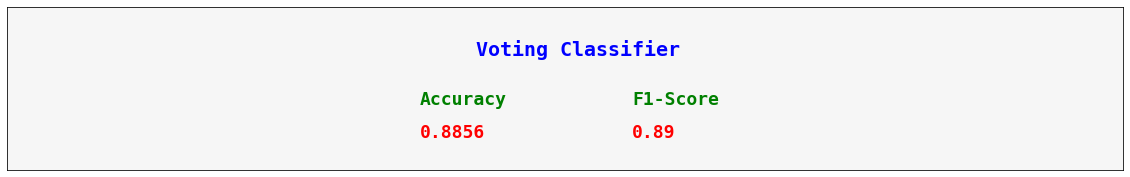

In [37]:
fig=plt.figure(figsize=(20,3))
gs=fig.add_gridspec(1,1)

ax0=fig.add_subplot(gs[0,0])

ax0.set_yticklabels('')
ax0.set_xticklabels('')
ax0.tick_params(axis='both',length=0)
ax0.set_facecolor('#F6F6F6')

ax0.text(0.42,0.7,'Voting Classifier',fontfamily='monospace',fontweight='bold',fontsize=20,color='blue')

ax0.text(0.37,0.4,'Accuracy',fontfamily='monospace',fontweight='bold',fontsize=18,color='green')
ax0.text(0.37,0.2,str(accuracy_score(y_test,voting_classifier_pipeline.predict(x_test))),fontfamily='monospace',fontweight='bold',fontsize=18,color='red')

ax0.text(0.56,0.4,'F1-Score',fontfamily='monospace',fontweight='bold',fontsize=18,color='green')
ax0.text(0.56,0.2,str(round(f1_score(y_test,voting_classifier_pipeline.predict(x_test)),2)),fontfamily='monospace',fontweight='bold',fontsize=18,color='red')

In [10]:
x=df['clean_text'].values
y=df['sentiment'].values

In [11]:
punctuationsCounter=Counter(string.punctuation)
words=OrderedDict()
n=0
for sentence in x:
    for word in sentence.split():
        if word not in string.punctuation and word not in words:
            words[n]=word
            n+=1

In [12]:
max_tokens=1000000
output_sequence_length=1000

In [11]:
max=-1
for sentence in df['clean_text']:
    length=len(sentence.split())
    if length>max:
        max=length
print(max)

1491


In [13]:
vectorizer=TextVectorization(max_tokens=max_tokens,
                            output_sequence_length=output_sequence_length,
                            output_mode='int')

In [14]:
vectorizer.adapt(x)

In [15]:
vectorized_x=vectorizer(x)

In [16]:
dataset=tf.data.Dataset.from_tensor_slices((vectorized_x,y))
dataset=dataset.cache()
dataset=dataset.shuffle(50000)
dataset=dataset.batch(20)
dataset=dataset.prefetch(10)

There are 2500 batches in the dataset and each batch has 20 observations.

In [17]:
len(dataset)

2500

In [18]:
##Takes the first 70% of the datset for training
train=dataset.take(int(len(dataset)*0.7))

##Skips the first 70% and takes the next 20% of the dataset for validation
val=dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))

##Skips the first 90% and takes the remaining 10% of the dataset for testing
test=dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [19]:
model=Sequential()

model.add(Embedding(max_tokens+1,50))
model.add(Bidirectional(LSTM(32)))
#model.add(Bidirectional(LSTM(64)))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [20]:
model.compile(loss='BinaryCrossentropy',metrics=['BinaryAccuracy','AUC'],optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          50000050  
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                21248     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 50,079,155
Trainable params: 50,079,155
Non-trainable params: 0
____________________________________________

In [22]:
history=model.fit(train,epochs=3,validation_data=val)

Epoch 1/3
1750/1750 [==============================] - 1173s 656ms/step - loss: 0.4446 - binary_accuracy: 0.7751 - auc: 0.8520 - val_loss: 0.1753 - val_binary_accuracy: 0.9406 - val_auc: 0.9811
Epoch 2/3
1750/1750 [==============================] - 2169s 1s/step - loss: 0.1849 - binary_accuracy: 0.9338 - auc: 0.9776 - val_loss: 0.1214 - val_binary_accuracy: 0.9634 - val_auc: 0.9910
Epoch 3/3
1750/1750 [==============================] - 1220s 697ms/step - loss: 0.1276 - binary_accuracy: 0.9583 - auc: 0.9878 - val_loss: 0.0805 - val_binary_accuracy: 0.9760 - val_auc: 0.9968


In [23]:
model.save('IMDBReviewsLSTMClassifier.h5')

In [59]:
model=keras.models.load_model('IMDBReviewsLSTMClassifier.h5')

In [62]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [24]:
precision=Precision()
recall=Recall()
accuracy=BinaryAccuracy()

In [25]:
for batch_x,batch_y in test.as_numpy_iterator():
    y_pred=model.predict(batch_x)
    
    y_pred=y_pred.flatten()
    y_true=batch_y.flatten()

    precision.update_state(y_true,y_pred)
    recall.update_state(y_true,y_pred)
    accuracy.update_state(y_true,y_pred)

In [26]:
print('Precision ',precision.result().numpy(),'Recall ',recall.result().numpy(),'Accuracy ',accuracy.result().numpy())

Precision  0.9894266 Recall  0.9548666 Accuracy  0.9717992


In [16]:
destination=os.path.join('reviewsClassifier','pickleObjects')
if not os.path.exists(destination):
    os.makedirs(destination)

# pickle.dump(stopwords_list,open(os.path.join(destination,'stopwords.pkl'),'wb'))## wb->Open for writing in binary mode

# pickle.dump({'config': vectorizer.get_config(),'weights': vectorizer.get_weights()}, open(os.path.join(destination,"vectorizer.pkl"), "wb"))

pickle.dump(logistic_classifier_pipeline,open(os.path.join(destination,'logisticClassifier.pkl'),'wb'))

#pickle.dump(model,open(os.path.join(destination,'lstmClassifier.pkl'),'wb'))